# Final assignment v1.1 - CO2 emissions

By: Thijs van Vliet

# 1. What is the biggest predictor of a large CO2 output per capita of a country?

To determine this you may want to consider things like GDP per capita, diets, number of cars per capita, various energy source, mobility and other factors.

Your answer can also be a specific combination of certain factors. Anyway, remember to include the explanations in your report.

In [61]:
# Loading the packages
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.patches as mpatches
import requests
from io import StringIO
import xlrd 
from sklearn.ensemble import RandomForestRegressor # # This is used to create a linear regression model.
from sklearn.impute import SimpleImputer # # This is used to impute missing values in the dataset.
from sklearn.model_selection import train_test_split # # This is used to split the data into training and testing sets.

##### Loading in the datasets via github. 

In [62]:
# Specify file paths via GitHub
file_path1 = 'https://raw.githubusercontent.com/TizzoBro/Winc-Academy/main/annual-co2-emissions-per-country.csv'
file_path2 = 'https://raw.githubusercontent.com/TizzoBro/Winc-Academy/main/co-emissions-per-capita.csv'
file_path3 = 'https://raw.githubusercontent.com/TizzoBro/Winc-Academy/main/world-data-2022%20%5BMConverter.eu%5D.csv'

# Load CSV files into DataFrames
annual_co2_per_country = pd.read_csv(file_path1, encoding='latin1').copy() # Using 'encoding='latin1'' because of UnicodeDecodeError otherwise. 
co2_capita = pd.read_csv(file_path2, encoding='latin1').copy()
World_data_2022 = pd.read_csv(file_path3, encoding='latin1').copy()

# Display first 5 rows and select first 5 columns of each DataFrame
display(annual_co2_per_country.head(), co2_capita.head(), World_data_2022.head())

,Entity,Code,Year,Annual CO2 emissions
0,Afghanistan,AFG,1949,14656.0
1,Afghanistan,AFG,1950,84272.0
2,Afghanistan,AFG,1951,91600.0
3,Afghanistan,AFG,1952,91600.0
4,Afghanistan,AFG,1953,106256.0


,Entity,Code,Year,Annual COâ emissions (per capita)
0,Afghanistan,AFG,1949,0.001992
1,Afghanistan,AFG,1950,0.011266
2,Afghanistan,AFG,1951,0.012098
3,Afghanistan,AFG,1952,0.011946
4,Afghanistan,AFG,1953,0.013685


,Country,Density,Abbreviation,Agricultural Land( %),Land Area(Km2),Armed Forces size,Birth Rate,Calling Code,Capital/Major City,Co2-Emissions,CPI,CPI Change (%),Currency-Code,Fertility Rate,Forested Area (%),Gasoline Price,GDP,Gross primary education enrollment (%),Gross tertiary education enrollment (%),Infant mortality,Largest city,Life expectancy,Maternal mortality ratio,Minimum wage,Official language,Out of pocket health expenditure,Physicians per thousand,Population,Population: Labor force participation (%),Tax revenue (%),Total tax rate,Unemployment rate,Urban_population,Latitude,Longitude
0,Afghanistan,60,AF,58.10%,65223.0,323.0,32.49,93.0,Kabul,8672.0,149.90,2.30%,AFN,4.47,2.10%,$0.70,$19101353833,104.00%,9.70%,47.9,Kabul,64.5,638.0,$0.43,Pashto,78.40%,0.28,38041754.0,48.90%,9.30%,71.40%,11.12%,9797273.0,3393911.0,67709953.0
1,Albania,105,AL,43.10%,28748.0,9.0,11.78,355.0,Tirana,4536.0,119.05,1.40%,ALL,1.62,28.10%,$1.36,$15278077447,107.00%,55.00%,7.8,Tirana,78.5,15.0,$1.12,Albanian,56.90%,1.20,2854191.0,55.70%,18.60%,36.60%,12.33%,1747593.0,41153332.0,20168331.0
2,Algeria,18,DZ,17.40%,2381741.0,317.0,24.28,213.0,Algiers,150006.0,151.36,2.00%,DZD,3.02,0.80%,$0.28,$169988236398,109.90%,51.40%,20.1,Algiers,76.7,112.0,$0.95,Arabic,28.10%,1.72,43053054.0,41.20%,37.20%,66.10%,11.70%,31510100.0,28033886.0,1659626.0
3,Andorra,164,AD,40.00%,468.0,NaN,7.20,376.0,Andorra la Vella,469.0,NaN,NaN,EUR,1.27,34.00%,$1.51,$3154057987,106.40%,NaN,2.7,Andorra la Vella,NaN,NaN,$6.63,Catalan,36.40%,3.33,77142.0,NaN,NaN,NaN,NaN,67873.0,42506285.0,1521801.0
4,Angola,26,AO,47.50%,1246700.0,117.0,40.73,244.0,Luanda,34693.0,261.73,17.10%,AOA,5.52,46.30%,$0.97,$94635415870,113.50%,9.30%,51.6,Luanda,60.8,241.0,$0.71,Portuguese,33.40%,0.21,31825295.0,77.50%,9.20%,49.10%,6.89%,21061025.0,-11202692.0,17873887.0


##### Transform and combine data

In [63]:
# Filtering by year
co2_2022_country = annual_co2_per_country[annual_co2_per_country['Year'] == 2022].copy()
co2_2022_capita = co2_capita[co2_capita['Year'] == 2022].copy()

# Changing column name for left join later
World_data_2022 = World_data_2022.rename(columns={'Country': 'Entity'})

# Combining
co2_2022 = pd.merge(co2_2022_country, co2_2022_capita, on='Entity', how='left')
co2_2022 = pd.merge(co2_2022, World_data_2022, on='Entity', how='left')

# Removing duplicate columns and renaming
co2_2022 = co2_2022.drop(columns=['Code_y', 'Year_y'])
co2_2022 = co2_2022.rename(columns={'Code_x': 'Code', 'Year_x': 'Year'})

# Dropping rows where 'Code' has NAs (these are countries that did not join properly)
co2_2022 = co2_2022.dropna(subset=['Code', 'Density'])

# Removing '%' character from values and converting to numeric
percentage_columns = ['Agricultural Land( %)', 'CPI Change (%)', 'Forested Area (%)', 
                      'Gross tertiary education enrollment (%)', 'Population: Labor force participation (%)',
                      'Tax revenue (%)', 'Total tax rate', 'Unemployment rate', 'Gross primary education enrollment (%)']

for column in percentage_columns:
    co2_2022[column] = pd.to_numeric(co2_2022[column].str.replace('%', ''))

co2_2022['Out of pocket health expenditure'] = pd.to_numeric(co2_2022['Out of pocket health expenditure'].str.replace('[$%]', '', regex=True))

# Doing the same for currency columns
currency_columns = ['Gasoline Price', 'GDP', 'Minimum wage']

for column in currency_columns:
    co2_2022[column] = pd.to_numeric(co2_2022[column].str.replace('[$]', '', regex=True))

# Display the merged DataFrame
print(co2_2022)
co2_2022.describe()

# Exporting to Excel
file_path4 = r'C:\Users\160514\OneDrive - Gemeente Rotterdam\Bureaublad\Winc Academy\Final Exercise\Data\co2_2022.xlsx'
co2_2022.to_excel(file_path4, index=False)

# Use .copy() to prevent warnings generated by Pandas or to avoid affecting the original DataFrame.

                               Entity Code  Year  Annual CO2 emissions  \
0                         Afghanistan  AFG  2022           1.214795e+07   
3                             Albania  ALB  2022           4.954730e+06   
4                             Algeria  DZA  2022           1.763451e+08   
5                             Andorra  AND  2022           3.686450e+05   
6                              Angola  AGO  2022           1.607027e+07   
8                 Antigua and Barbuda  ATG  2022           6.021920e+05   
9                           Argentina  ARG  2022           1.928644e+08   
10                            Armenia  ARM  2022           6.407760e+06   
15                          Australia  AUS  2022           3.922793e+08   
16                            Austria  AUT  2022           6.148842e+07   
17                         Azerbaijan  AZE  2022           3.806266e+07   
19                            Bahrain  BHR  2022           3.779567e+07   
20                       

To find out which predictor (attribute) has the highest correlation or influence on CO2 emissions per capita, you can use statistical methods such as correlation analysis or regression analysis. I do this using pandas and scikit-learn.

In [64]:
# Drop multiple columns
columns_to_drop = ['Entity', 'Year', 'Code', 'Abbreviation', 'Capital/Major City', 'Currency-Code', 'Largest city', 'Official language', 'Latitude', 'Longitude']
co2_2022_cor = co2_2022.drop(columns=columns_to_drop).copy()

# Split the data into predictors and target variable
X = co2_2022_cor.drop(columns=['Annual COâ emissions (per capita)']).copy()
y = co2_2022_cor['Annual COâ emissions (per capita)'].copy()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train a random forest regressor model
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Get feature importances
feature_importances = model.feature_importances_

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the DataFrame showing feature importances
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
print(feature_importance_df)

# Exporting to Excel
file_path5 = r'C:\Users\160514\OneDrive - Gemeente Rotterdam\Bureaublad\Winc Academy\Final Exercise\Data\feature_importance_df.xlsx'
feature_importance_df.to_excel(file_path5, index=False)

                                      Feature  Importance
12                             Gasoline Price    0.212191
25                             Total tax rate    0.152731
16                           Infant mortality    0.074373
18                   Maternal mortality ratio    0.070456
21                    Physicians per thousand    0.062301
26                          Unemployment rate    0.048509
11                          Forested Area (%)    0.036628
1                                     Density    0.035774
2                       Agricultural Land( %)    0.029520
24                            Tax revenue (%)    0.026058
10                             Fertility Rate    0.025663
8                                         CPI    0.025394
19                               Minimum wage    0.025241
15    Gross tertiary education enrollment (%)    0.025122
5                                  Birth Rate    0.021514
23  Population: Labor force participation (%)    0.018301
9             

C:\Users\160514\AppData\Local\Temp\ipykernel_12240\495220111.py:38: UserWarning: Glyph 130 (\x82) missing from current font.
  plt.tight_layout()
C:\Users\160514\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 130 (\x82) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


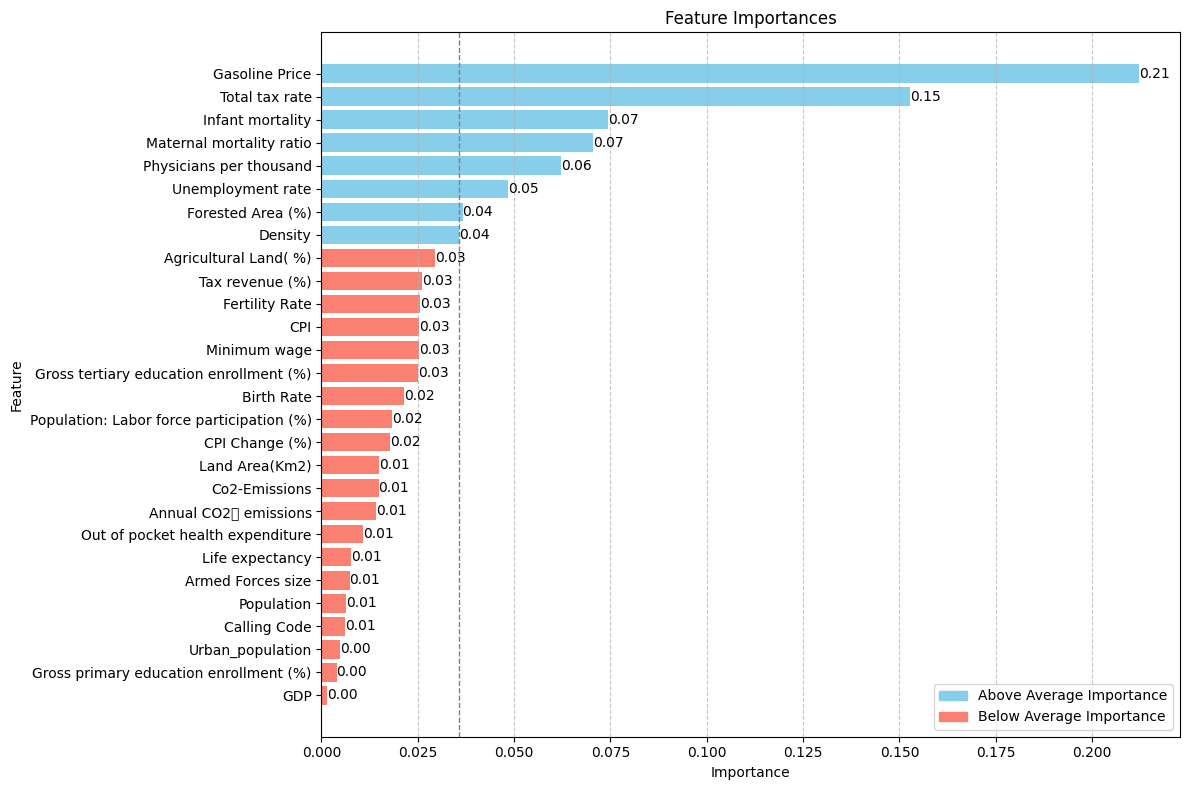

In [65]:
# Plotting feature importances
plt.figure(figsize=(12, 8))

# Calculate average importance
average_importance = np.mean(feature_importance_df['Importance'])

# Define custom colors for feature importances
colors = ['skyblue' if imp >= average_importance else 'salmon' for imp in feature_importance_df['Importance']]

# Creating a horizontal bar plot to visualize the importance of features, where each bar represents a feature, its length represents its importance score, and the colors of the bars may vary.
bars = plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color=colors)
plt.xlabel('Importance') # This sets the label for the x-axis of the plot to 'Importance'.
plt.ylabel('Feature') # This sets the label for the y-axis of the plot to 'Feature'.
plt.title('Feature Importances') # This sets the title of the plot to 'Feature Importances'.
plt.gca().invert_yaxis()  # Invert y-axis to show the most important features at the top

# Add average line
plt.axvline(x=average_importance, color='gray', linestyle='--', linewidth=1)

# Add vertical gridlines
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Define legend labels
legend_labels = ['Above Average Importance', 'Below Average Importance']

# Define legend handles with custom symbols
above_average_importance_patch = mpatches.Patch(color='skyblue', label='Above Average Importance')
below_average_importance_patch = mpatches.Patch(color='salmon', label='Below Average Importance')

# Add legend with custom symbols
plt.legend(handles=[above_average_importance_patch, below_average_importance_patch], loc='lower right')

# Add labels for each bar
for bar, label in zip(bars, feature_importance_df['Importance']):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{label:.2f}', 
             va='center', ha='left', fontsize=10, color='black')

plt.tight_layout()
plt.show()


### Interpreting the dataframe 'feature_importance_df'

Importance: This column represents the importance of each feature in predicting the target variable. The importance is calculated based on how much each feature decreases the impurity in the decision tree nodes during training. Higher values indicate more important features, while lower values indicate less important features.

Higher Importance: Features with higher importance values are more influential in predicting the target variable. These features have a stronger impact on the model's predictions.

Lower Importance: Features with lower importance values are less influential in predicting the target variable. These features contribute less to the model's predictions.

##### Conclusion
Gasoline Price: This characteristic is of utmost importance, indicating that variations in gasoline prices have a significant impact on predicting annual CO₂ emissions per capita.

Total Tax Rate: This attribute is the second most important, indicating that the total tax rate also plays a crucial role in predicting annual per capita CO₂ emissions.

Overall, this analysis provides insight into which characteristics are most influential in predicting annual per capita CO₂ emissions in this model.

# 2. Which countries are making the biggest strides in decreasing CO2 output?

You'll need to find the relative CO2 output for each country to be able to calculate this. But countries can have growing and shrinking populations too, so it's probably a good idea to take this into account as well.

To find out the biggest strides in decreasing CO2 output, you can calculate the relative change in CO2 emissions per capita over a specific period, considering both changes in CO2 emissions and changes in population size for each country. Here will be my general approach:

1. Calculate CO2 emissions per capita for each country: Divide the total CO2 emissions by the population size for each country to get the CO2 emissions per capita.

2. Choose a reference year: Select a starting year and an ending year for your analysis. This will define the period over which you'll calculate the change in CO2 emissions per capita.

3. Calculate the relative change in CO2 emissions per capita: For each country, subtract the CO2 emissions per capita in the starting year from the CO2 emissions per capita in the ending year. This will give you the change in CO2 emissions per capita over the chosen period.

4. Rank countries by the relative change: Rank the countries based on the calculated relative change in CO2 emissions per capita. Countries with the largest negative changes (decreasing CO2 emissions per capita) will indicate the biggest strides in decreasing CO2 output.

1. Calculate Co2 emissions per capita. Dataframe co2_capita needed. Here the Annual CO₂ emissions (per capita) is already given; no need to calculate.

In [66]:
# Display the first 10 rows and 10 columns of the DataFrame
display(co2_capita.iloc[:10, :10])

,Entity,Code,Year,Annual COâ emissions (per capita)
0,Afghanistan,AFG,1949,0.001992
1,Afghanistan,AFG,1950,0.011266
2,Afghanistan,AFG,1951,0.012098
3,Afghanistan,AFG,1952,0.011946
4,Afghanistan,AFG,1953,0.013685
5,Afghanistan,AFG,1954,0.013511
6,Afghanistan,AFG,1955,0.019304
7,Afghanistan,AFG,1956,0.022652
8,Afghanistan,AFG,1957,0.035702
9,Afghanistan,AFG,1958,0.039569


2. Reference years: 1990 and 2020

In [67]:
# Choose a reference year range
years = [1990, 2020]

# Filter data for the selected reference year range
reference_data = co2_capita[co2_capita['Year'].isin(years)].copy()

# Pivot the data to have CO2 emissions per capita for the selected years in separate columns
reference_pivot = reference_data.pivot(index='Entity', columns='Year', values='Annual COâ emissions (per capita)')

# Calculate the relative change in CO2 emissions per capita for each pair of selected years
for i in range(len(years) - 1):
    start_year = years[i]
    end_year = years[i + 1]
    reference_pivot[f'Relative_change_{start_year}_{end_year}'] = reference_pivot[end_year] - reference_pivot[start_year]

# Sort the DataFrame by the relative change in CO2 emissions per capita for the latest pair of years
latest_start_year = years[-2]
latest_end_year = years[-1]
largest_strides = reference_pivot.sort_values(by=f'Relative_change_{latest_start_year}_{latest_end_year}', ascending=True)

# Display the DataFrame showing countries with the biggest strides in decreasing CO2 output
print(largest_strides)


Year                                   1990       2020  \
Entity                                                   
Curacao                           31.029930   9.542373   
Luxembourg                        30.989450  12.797711   
Estonia                           23.505550   6.949406   
Ukraine                           13.689269   4.710213   
Nauru                             12.949688   4.157225   
Czechia                           15.944803   8.707416   
United States                     20.642052  14.034053   
Moldova                            8.088808   1.699024   
Slovakia                          11.683941   5.698817   
Russia                            17.136150  11.213840   
Europe (excl. EU-27)              13.734913   7.949374   
United Kingdom                    10.521594   4.865282   
Europe (excl. EU-28)              14.481453   8.830373   
Denmark                           10.394725   4.857781   
Germany                           13.288876   7.767432   
Singapore     

The following code  selects the top 10 countries (the top_n variable) with the biggest strides in decreasing CO2 output, calculates their average relative change, defines colors and legend labels accordingly, and plots the data in a horizontal bar chart.

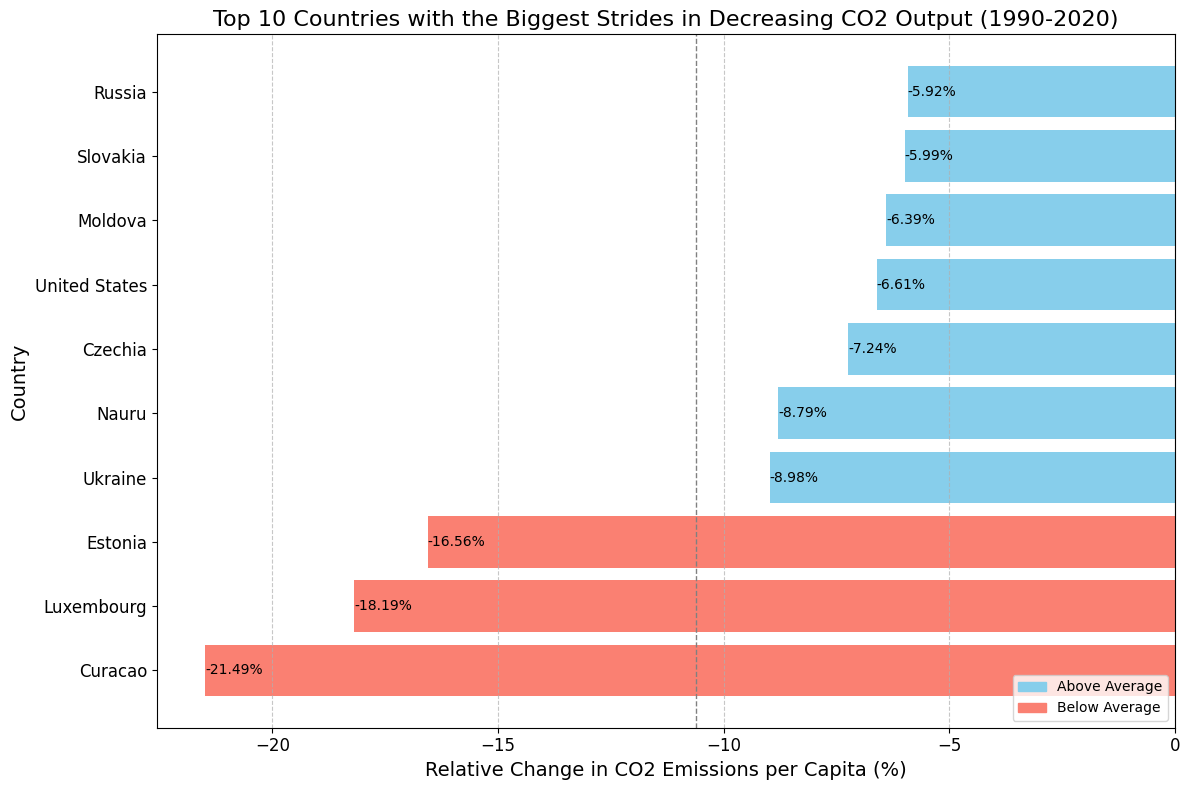

In [68]:
top_n = 10  # Define top_n as 10 the top 10 countries with biggest strides

# Drop rows with NaN values and make a copy
bottom_countries = largest_strides.dropna().head(top_n).copy()

# Calculate average relative change
average_relative_change = np.mean(bottom_countries[f'Relative_change_{latest_start_year}_{latest_end_year}'])

# Define custom colors based on whether the relative change is above or below average. It assigns 'skyblue' to the color list if the value x is greater than or equal to the average_relative_change, otherwise 'salmon'.
colors = ['skyblue' if x >= average_relative_change else 'salmon' for x in bottom_countries[f'Relative_change_{latest_start_year}_{latest_end_year}']]

# Define legend labels
legend_labels = ['Above Average', 'Below Average']

# Define legend handles with custom symbols
above_average_patch = mpatches.Patch(color='skyblue', label='Above Average')
below_average_patch = mpatches.Patch(color='salmon', label='Below Average')

# Plotting
plt.figure(figsize=(12, 8))
bars = plt.barh(bottom_countries.index, bottom_countries[f'Relative_change_{latest_start_year}_{latest_end_year}'], color=colors)

# Add labels for each bar
for bar, label in zip(bars, bottom_countries[f'Relative_change_{latest_start_year}_{latest_end_year}']):
    plt.text(bar.get_x() + bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{label:.2f}%', 
             va='center', ha='left', fontsize=10, color='black')

# Add average line
plt.axvline(x=average_relative_change, color='gray', linestyle='--', linewidth=1)

plt.xlabel('Relative Change in CO2 Emissions per Capita (%)', fontsize=14)
plt.ylabel('Country', fontsize=14)
plt.title(f'Top {top_n} Countries with the Biggest Strides in Decreasing CO2 Output ({latest_start_year}-{latest_end_year})', fontsize=16)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add legend with custom symbols
plt.legend(handles=[above_average_patch, below_average_patch], loc='lower right')

plt.tight_layout()
plt.show()



##### The table and figure shows the relative change in CO2 emissions per capita for the top 10 countries between the years 1990 and 2020. Here's how to interpret it:

CO2 Emissions Per Capita (1990 and 2020): Each row represents a different entity (e.g., country or region), and the columns represent the CO2 emissions per capita for the years 1990 and 2020, respectively. The values in these columns indicate the amount of CO2 emissions (in metric tons) produced per person in each entity for the corresponding year.

For example, if the relative change is -10%, it means that CO2 emissions per capita decreased by 10% from 1990 to 2020.
If the relative change is +20%, it means that CO2 emissions per capita increased by 20% from 1990 to 2020.

Countries with negative values in the "Relative_change" axis have experienced a decrease in CO2 emissions per capita from 1990 to 2020. The larger the negative value, the greater the reduction in emissions per capita. A country being below average actually means that they have above average strides in decreasing the CO2 emissions output (per capita). 

Countries like Curacao, Luxembourg, and Estonia have experienced significant decreases in CO2 emissions per capita, indicating successful efforts in reducing emissions intensity.
On the other hand, countries like Qatar, Trinidad and Tobago, and New Caledonia (not shown in the graph) have seen substantial increases in CO2 emissions per capita, suggesting a rise in emissions intensity over the same period.

# 3. Which non-fossil fuel energy technology will have the best price in the future?

Best future price for non-fossil fuel energy. To be able to predict prices you'll probably need to use linear regression over the various non-fossil fuel options.

Loading in dataset: Average prices for wind turbines, solar panels, storage battaeries, and EV batteries, 2014-2022

In [69]:
# Specify file path
file_path6 = 'https://raw.githubusercontent.com/TizzoBro/Winc-Academy/main/average-prices-for-selected-technologies-2014-2022.csv' # from https://www.iea.org/data-and-statistics/charts/average-prices-for-selected-technologies-2014-2022

# Load CSV file into a DataFrame and make a copy
avg_price_renew_energy = pd.read_csv(file_path6, encoding='latin1').copy()

# Display the DataFrame
display(avg_price_renew_energy)

,Year,Wind turbines,Solar panels,Storage batteries,EV batteries
0,2014,1.2,0.7,1.8,2.2
1,2015,1.0,0.7,1.8,1.6
2,2016,0.9,0.6,1.8,1.2
3,2017,0.9,0.4,1.6,0.9
4,2018,0.8,0.3,1.5,0.7
5,2019,0.8,0.2,1.4,0.6
6,2020,0.8,0.2,1.2,0.6
7,2021,0.8,0.2,1.1,0.5
8,2022,0.8,0.2,1.1,0.6


The data is from 2014 to 2022 and shows (in millions) the average price USD/Megawatt (nominal prices) average in the world

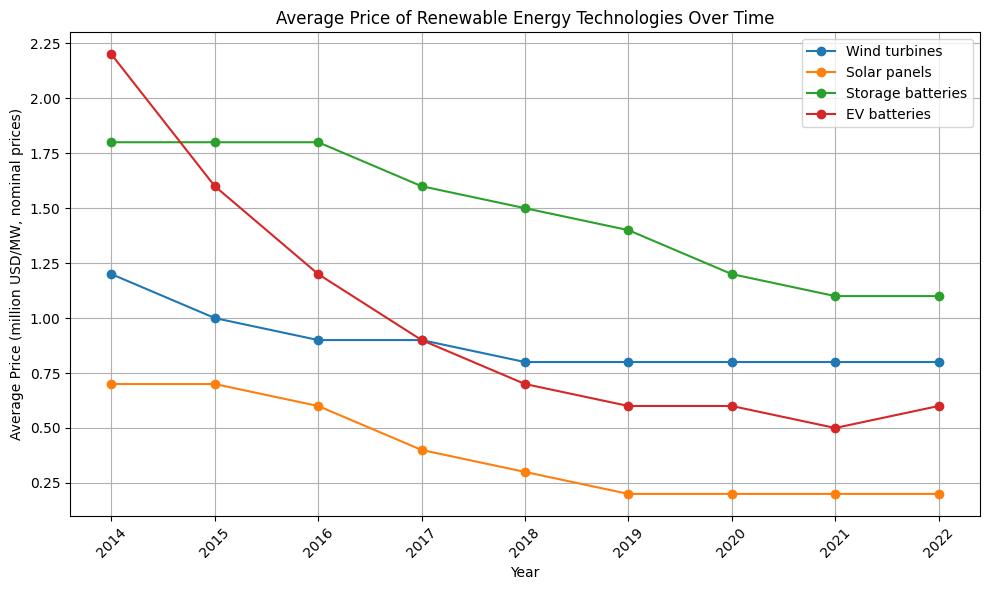

In [70]:
# Adjust the figure size 
plt.figure(figsize=(10, 6))

# The lines below plot the average price of different renewable energy technologies over time. Each plt.plot() function call creates a line plot for a specific technology. 
# The x-axis values are taken from the 'Year' column of the DataFrame, and the y-axis values are taken from the corresponding technology columns. 
# The marker='o' argument specifies that data points should be marked with circular markers, and the label argument provides a label for each line plot.
plt.plot(avg_price_renew_energy['Year'], avg_price_renew_energy['Wind turbines'], marker='o', label='Wind turbines')
plt.plot(avg_price_renew_energy['Year'], avg_price_renew_energy['Solar panels'], marker='o', label='Solar panels')
plt.plot(avg_price_renew_energy['Year'], avg_price_renew_energy['Storage batteries'], marker='o', label='Storage batteries')
plt.plot(avg_price_renew_energy['Year'], avg_price_renew_energy['EV batteries'], marker='o', label='EV batteries')

# Title
plt.title('Average Price of Renewable Energy Technologies Over Time')

# Legend 
plt.xlabel('Year')
plt.ylabel('Average Price (million USD/MW, nominal prices)')  # Modified y-axis label
plt.legend()

# Adding gridlines
plt.grid(True)

#This line sets the tick positions and labels on the x-axis. It takes the 'Year' column from the DataFrame avg_price_renew_energy as the tick positions and rotates the labels by 45 degrees for better readability.
plt.xticks(avg_price_renew_energy['Year'], rotation=45)  # Rotate x-axis labels for better visibility

# Adjusting layout and showing plot
plt.tight_layout()
plt.show()



##### Interpretation
The graph illustrates the average prices of various renewable energy technologies over the years, expressed in million USD/MW (nominal prices). Here's a breakdown of the interpretation:

Wind turbines: The line representing wind turbine prices shows a gradual decline from around 1.2 million USD/MW in 2014 to approximately 0.8 million USD/MW in 2022. This indicates a decreasing trend in the average price of wind turbines over the years.

Solar panels: Similarly, the line for solar panel prices demonstrates a decline from 0.7 million USD/MW in 2014 to about 0.2 million USD/MW in 2022. This indicates a significant reduction in the average price of solar panels over the period.

Storage batteries: The average prices of storage batteries, depicted by the line, have decreased steadily from 1.8 million USD/MW in 2014 to approximately 1.1 million USD/MW in 2022, showing a consistent downward trend.

EV batteries: The line representing EV battery prices also exhibits a decline from 2.2 million USD/MW in 2014 to around 0.6 million USD/MW in 2022, indicating a substantial decrease in the average price of electric vehicle batteries over the years.

Overall, the graph demonstrates a positive trend in the affordability of renewable energy technologies, with decreasing average prices for wind turbines, solar panels, storage batteries, and EV batteries over the analyzed period. This reduction in prices suggests advancements in technology, economies of scale, and possibly supportive policies, making renewable energy sources more accessible and competitive compared to conventional energy sources.

#### Application of regression: loading dataset

In [71]:
# Specify file path
file_path7 = 'https://raw.githubusercontent.com/TizzoBro/Winc-Academy/main/01_SPM3_costs_adoption.csv' # Data from https://ipcc-browser.ipcc-data.org/browser/dataset?id=443

# Load CSV file into a DataFrame and make a copy
costs_non_fossil_fuel = pd.read_csv(file_path7, encoding='latin1').copy()

# Display the DataFrame
display(costs_non_fossil_fuel)

,Year,Solar PV,Solar CSP,Onshore wind,Offshore wind,Li Ion Battery packs
0,2002,545.244623,NaN,120.487630,118.528217,NaN
1,2003,470.022833,NaN,107.100115,109.252096,NaN
2,2004,444.566813,NaN,112.249159,137.080460,NaN
3,2005,440.198580,NaN,105.040498,106.160055,NaN
4,2006,465.333182,NaN,106.070306,109.252096,1438.011889
5,2007,453.754883,NaN,98.861645,180.369026,1247.740037
6,2008,441.421482,NaN,88.563557,137.080460,1070.756491
7,2009,372.511309,NaN,87.533748,158.724743,937.972196
8,2010,380.563083,343.537329,89.471617,161.619332,940.753955
9,2011,289.260748,339.384336,83.463459,170.893898,777.999532


This code essentially automates the process of fitting linear regression models for each technology, predicting prices for the year 2024, and determining the best technology based on predicted prices.

In [72]:
# Impute missing values using median and make a copy
imputer = SimpleImputer(strategy='median') # missing values will be replaced with the median of the respective column.
costs_non_fossil_fuel_imputed = costs_non_fossil_fuel.fillna(costs_non_fossil_fuel.median()).copy()

# Select features and target
X = costs_non_fossil_fuel_imputed[['Year']].copy()  # Make a copy of the DataFrame slice
y = costs_non_fossil_fuel_imputed.drop(['Year'], axis=1).copy()  # Make a copy of the DataFrame slice

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # Splits the data into training and testing sets using train_test_split, with 80% of the data used for training and 20% for testing.

# Fit linear regression models for each technology
models = {}
for column in y.columns: # For each technology (each column in y), it initializes a LinearRegression model with fit_intercept=False to fit a linear regression model without intercept.
    lr = LinearRegression(fit_intercept=False)  # Set fit_intercept to False
    lr.fit(X_train, y_train[column]) # fits the model using the training data (X_train and y_train) for each technology and stores the models in a dictionary called models.
    models[column] = lr

# Predict prices for the year 2024
predicted_prices = {}
for tech, model in models.items():
    predicted_prices[tech] = model.predict([[2024]])

# Find the technology with the lowest predicted price in 2024
best_technology = min(predicted_prices, key=predicted_prices.get)
print("Best technology in 2024:", best_technology)


Best technology in 2024: Onshore wind


C:\Users\160514\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\160514\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\160514\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\160514\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:493: Us

Generating a bar plot to visualize the predicted prices for non-fossil fuel energy technologies in the year 2024:

C:\Users\160514\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\160514\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\160514\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\160514\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:493: Us

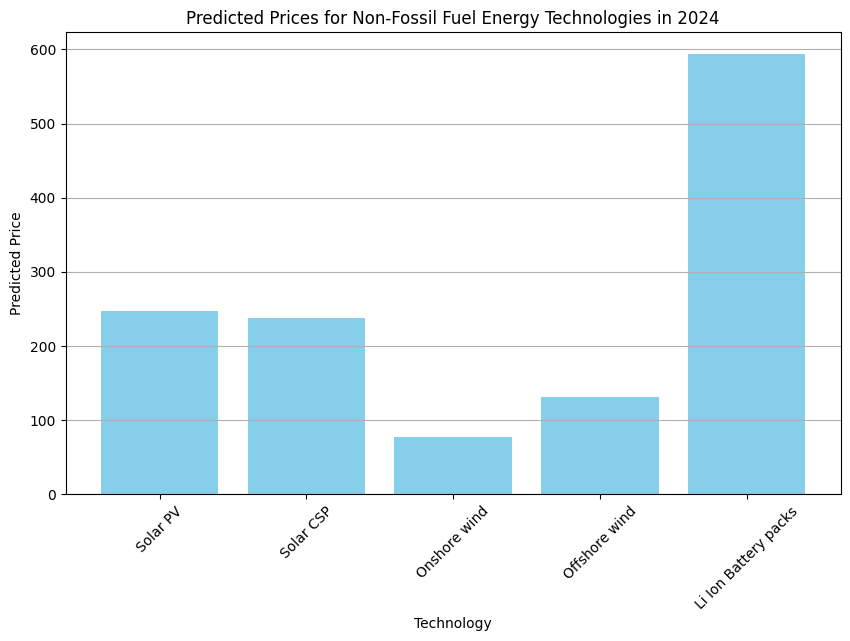

In [73]:
# Predicted prices for the year 2024
predicted_prices = {}
for tech, model in models.items():
    predicted_prices[tech] = model.predict([[2024]])

# Separate keys (technologies) and values (predicted prices)
technologies = list(predicted_prices.keys())
prices = [predicted_prices[tech][0] for tech in technologies]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(technologies, prices, color='skyblue')
plt.title('Predicted Prices for Non-Fossil Fuel Energy Technologies in 2024')
plt.xlabel('Technology')
plt.ylabel('Predicted Price')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


In this statistical analysis, onshore wind has the lowest predicted price for non-fossil fuel energy technologies in 2024.